# National Inventory of Dams

In [1]:
import geopandas as gpd
from pygeohydro import NID

In [2]:
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 300, "facecolor": "w"}
CRS = "esri:102008"

First, we need to instantiate the NID class.

In [3]:
nid = NID()

`NID` has a property called `attrs` that contains descriptions of NID variables and their units.

In [4]:
nid.attrs.head(5)

,description,unit
DAM_NAME,The official name of the dam. No abbreviations...,Alphanumeric
OTHER_DAM_NAME,"Names other than the official name (i.e., rese...",Alphanumeric
DAM_FORMER_NAME,"Previous reservoir or dam name(s), if changed....",Alphanumeric
NIDID,The official NID identification number for the...,Alphanumeric
LONGITUDE,Longitude at dam centerline as a single value ...,Number


Now, let's get definitions of each types of dams.

In [5]:
dam_types = dict(
    s.split(" for ")
    for s in nid.attrs.loc["DAM_TYPE", "description"].split(":")[1].split(".")[0].split(";")
)

Some of the dam coordinates are either missing or incorrect. Let's get dams that are within Contiguous US.

In [6]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
conus_geo = world[world.name == "United States of America"].geometry.iloc[0][0]
conus = gpd.GeoDataFrame(geometry=[conus_geo], crs=world.crs)
conus_dams = nid.bygeom(conus_geo, "epsg:4326")

Found 90,758 features in the requested region.


Next, we can get a count of the top 10 dams based on types.

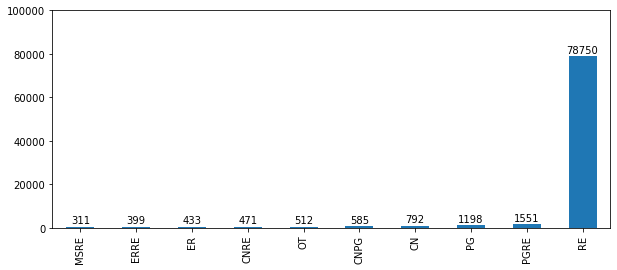

In [7]:
types_count = conus_dams["DAM_TYPE"].value_counts()
ax = types_count.sort_values()[-10:].plot.bar(figsize=(10, 4))
ax.set_ylim(0, 10e4)
for p in ax.patches:
    ax.annotate(
        p.get_height(),
        (p.get_x() + p.get_width() / 2, p.get_height() + 3000),
        ha="center",
        va="center",
    )

Let's compare the spatial distribution of the top five categories, excluding Earth and Other categories.

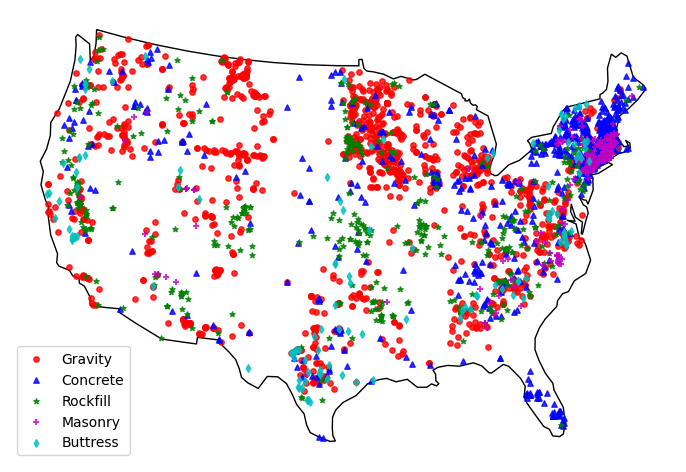

In [8]:
ax = conus.to_crs(CRS).plot(figsize=(10, 6), facecolor="none", edgecolor="k")
top_types = ["PG", "CN", "ER", "MS", "CB"]
marker = dict(zip(top_types, ["o", "^", "*", "+", "d"]))
color = dict(zip(top_types, ["r", "b", "g", "m", "c"]))
conus_dams = conus_dams.to_crs(CRS)
for c in top_types:
    conus_dams[conus_dams.DAM_TYPE == c].plot(
        ax=ax,
        alpha=0.8,
        markersize=15,
        marker=marker[c],
        color=color[c],
        label=dam_types[c],
    )
ax.legend()
ax.axis(False)
ax.figure.set_dpi(100)
ax.figure.savefig("_static/dams.png", **SAVE_KWDS)